# Chapter 17: Regression-based Forecasting

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition)
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

Make sure DMBA package is available

In [56]:
pip install dmba

In [57]:
from pathlib import Path

import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_squared_error, mean_absolute_error

import dmba

%matplotlib inline


## Figure 17.1

In [67]:
# load data and convert to time series
Amtrak_df = dmba.load_data('Amtrak.csv')

# convert the date information to a datetime object
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')

# convert dataframe column to series (name is used to label the data)
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')

# define the time series frequency
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

#add a trend
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')



In [68]:
ridership_df.head()

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0
1991-03-01,1972.715,1.0,3.0
1991-04-01,1811.665,1.0,4.0
1991-05-01,1974.964,1.0,5.0


In [69]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

In [70]:
# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
print(ridership_lm.summary())

predict_df = ridership_lm.predict(valid_df)

#root mean square error
mse = mean_squared_error(valid_df['Ridership'], predict_df)
rmse = np.sqrt(mse)
print(rmse)

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Wed, 27 Sep 2023   Prob (F-statistic):              0.390
Time:                        17:39:12   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.0

In [71]:

ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)

ridership_lm_expo.summary()

mse = mean_squared_error(valid_df['Ridership'], predict_df_expo)
rmse = np.sqrt(mse)
print(rmse)

1990.7907041520848


In [64]:
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()
predict_df_poly = ridership_lm_poly.predict(valid_df)
ridership_lm_poly.summary()

mse = mean_squared_error(valid_df['Ridership'], predict_df_poly)
rmse = np.sqrt(mse)
print(rmse)


179.84942266652334


In [65]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()
predict_df_season = ridership_lm_season.predict(valid_df)
ridership_lm_season.summary()


mse = mean_squared_error(valid_df['Ridership'], predict_df_season)
rmse = np.sqrt(mse)
print(rmse)

229.65091956721403


In [66]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]
ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()
predict_df_trendseason = ridership_lm_trendseason.predict(valid_df)

print(ridership_lm_trendseason.summary())


mse = mean_squared_error(valid_df['Ridership'], predict_df_trendseason)
rmse = np.sqrt(mse)
print(rmse)

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           3.75e-35
Time:                        17:37:16   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

Smoothing-Moving Average

In [72]:
# centered moving average with window size = 12
ma_centered = ridership_ts.rolling(12, center=True).mean()

# trailing moving average with window size = 12
ma_trailing = ridership_ts.rolling(12).mean()

# shift the average by one time unit
#ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
#ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])


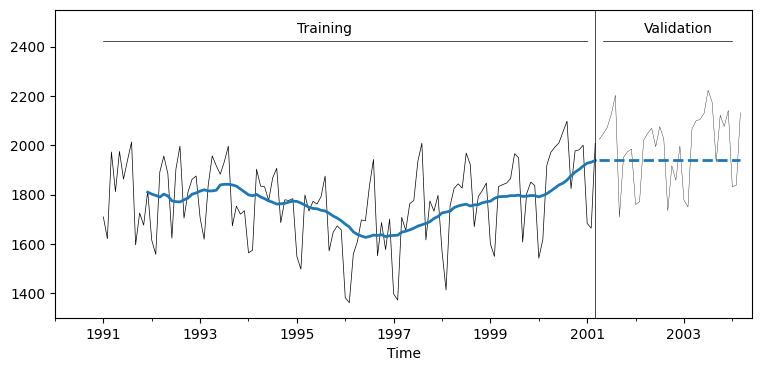

In [73]:
# partition the data
nValid = 36
nTrain = len(ridership_ts) - nValid

train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# moving average on training
ma_trailing = train_ts.rolling(12).mean()
last_ma = ma_trailing[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()

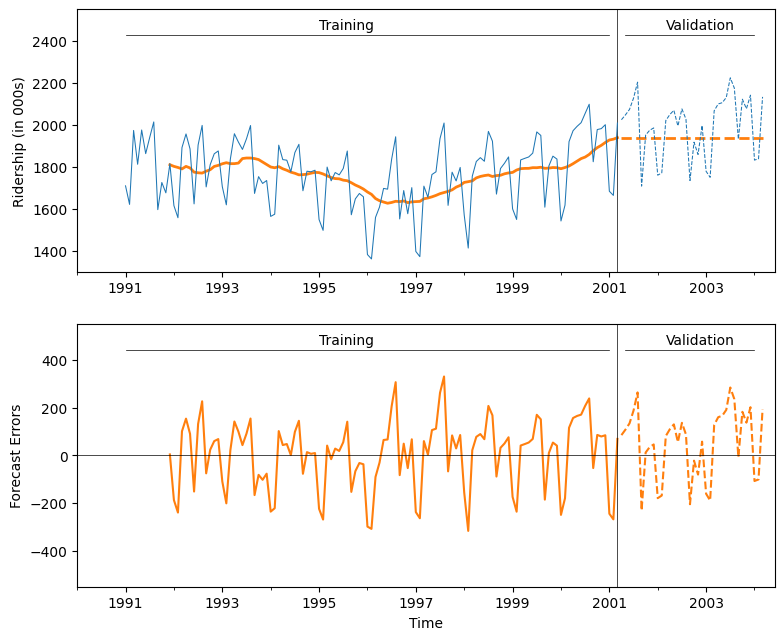

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ma_trailing.plot(ax=axes[0], linewidth=2, color='C1')
ma_trailing_pred.plot(ax=axes[0], linewidth=2, color='C1', linestyle='dashed')

residual = train_ts - ma_trailing
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - ma_trailing_pred
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_ts, valid_ts)

plt.show()

In [75]:
# Build a model with seasonality, trend, and quadratic trend
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
ridership_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# create single-point forecast
ridership_prediction = ridership_lm_trendseason.predict(valid_df.iloc[0, :])

# apply MA to residuals
ma_trailing = ridership_lm_trendseason.resid.rolling(12).mean()

print('Prediction', ridership_prediction[0])
print('ma_trailing', ma_trailing[-1])

Prediction 2004.270892764497
ma_trailing 30.780684624060125
